In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Load dataset
data = pd.read_csv('data.csv')

# Define xcols and ycols
xcols = ['fw', 'inl', 'pl', 'x']
ycols = ['freq', 's11', 'gain']

# Separate features and targets
X = data[xcols].values
y = data[ycols].values

# Split data into train, validation, and test sets (70-15-15 split) BEFORE scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [32]:
X_test[:5], y_test[:5]

(array([[ 1.5,  3. , 14. ,  3. ],
        [ 2.7,  2. , 16. ,  2. ],
        [ 1.5,  5. , 19. ,  3. ],
        [ 3.3,  5. , 20. ,  2. ],
        [ 1.5,  6. , 20. ,  1.5]]),
 array([[  4.4463    , -19.34107864,   6.60116995],
        [  4.0592    , -19.60345641,   6.43523666],
        [  3.4859    , -34.92145351,   3.88466878],
        [  3.4026    , -11.76603428,   3.19135699],
        [  3.3438    , -31.07642371,   2.60248952]]))

In [33]:
# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit only on training data
X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train)

# Transform validation and test data using the same scaler
X_val = scaler_X.transform(X_val)
y_val = scaler_y.transform(y_val)
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [34]:
import torch.nn.functional as F

class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.3):
        super(FeedForwardNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, output_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout with given probability

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)  # Dropout after activation
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.relu(self.layer4(x))
        x = self.dropout(x)
        x = self.relu(self.layer5(x))
        x = self.layer6(x)  # No dropout on output layer
        return x

Epoch [50/500], Train Loss: 0.062213, Validation Loss: 0.046419
Epoch [100/500], Train Loss: 0.036229, Validation Loss: 0.016356
Epoch [150/500], Train Loss: 0.026763, Validation Loss: 0.012516
Epoch [200/500], Train Loss: 0.021613, Validation Loss: 0.010496
Epoch [250/500], Train Loss: 0.017965, Validation Loss: 0.013788
Epoch [300/500], Train Loss: 0.016101, Validation Loss: 0.012192
Epoch [350/500], Train Loss: 0.013462, Validation Loss: 0.009069
Epoch [400/500], Train Loss: 0.012010, Validation Loss: 0.008985
Epoch [450/500], Train Loss: 0.010425, Validation Loss: 0.006715
Epoch [500/500], Train Loss: 0.008974, Validation Loss: 0.006321


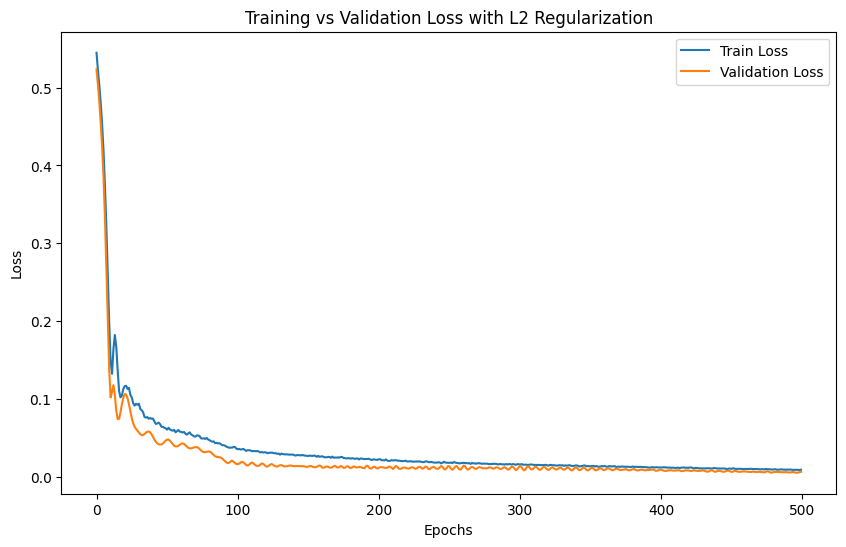

In [35]:
# Initialize model
model = FeedForwardNN(input_dim=X_train.shape[1], output_dim=y_train.shape[1])

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# Training loop
epochs = 500
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    
    # Forward pass
    predictions = model(X_train)
    train_loss = criterion(predictions, y_train)
    
    # Backward pass
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Validation loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val)
        val_loss = criterion(val_predictions, y_val)

    # Record losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    # Print training progress
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.6f}, Validation Loss: {val_loss.item():.6f}")

# Plot the train and validation loss over time
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss with L2 Regularization")
plt.show()

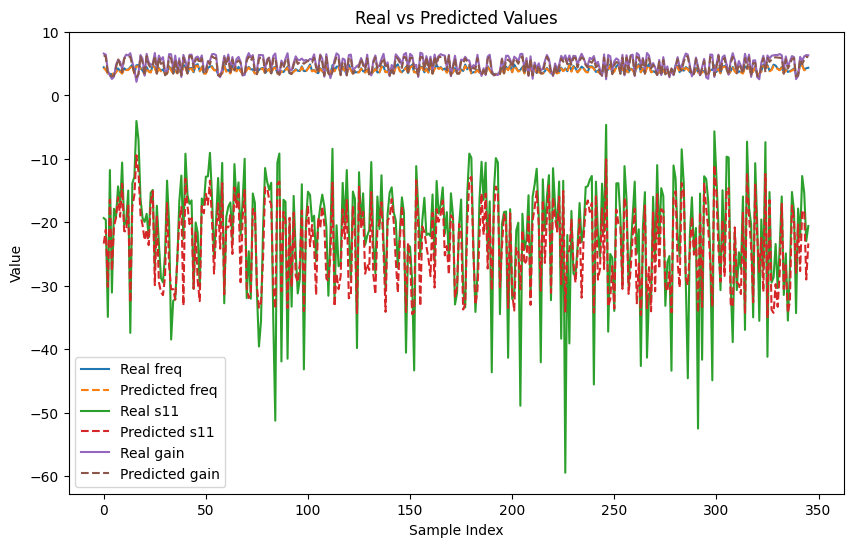

In [36]:
# Make predictions on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Inverse scale the predictions and true values
y_pred_inv = scaler_y.inverse_transform(y_pred.numpy())
y_test_inv = scaler_y.inverse_transform(y_test.numpy())

# Plot real vs predicted
plt.figure(figsize=(10, 6))
for i in range(y_pred_inv.shape[1]):
    plt.plot(y_test_inv[:, i], label=f'Real {ycols[i]}')
    plt.plot(y_pred_inv[:, i], label=f'Predicted {ycols[i]}', linestyle='--')
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.title("Real vs Predicted Values")
plt.show()

In [37]:
# Calculate MSE, MAE, RMSE, R^2 on the test set
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MSE: 7.718240261077881
MAE: 1.4040279388427734
RMSE: 2.7781721078935844
R^2: 0.851071834564209


In [38]:
# Also save the scalers
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [39]:
torch.save(model.state_dict(), 'model.pth')